In [1]:
import keras
from keras.layers import Layer, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D
from keras import Model
import tensorflow as tf

In [2]:
# Autoencoder

class Encoder(Layer):
    def __init__(self, code_dim=16, name="encoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.code_dim = code_dim

        self.conv1 = Conv2D(16, 3, activation='relu')
        self.conv2 = Conv2D(32, 3, activation='relu')
        self.max_pool = MaxPooling2D(3)
        self.conv3 = Conv2D(32, 3, activation='relu')
        self.conv4 = Conv2D(self.code_dim, 3, activation='relu')
        self.global_max_pool = GlobalMaxPooling2D()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        encoder_output = self.global_max_pool(x)

        return encoder_output

class Decoder(Layer):
    def __init__(self, code_dim=16, name="decoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.reshape_side = int(code_dim ** 0.5)
        self.reshape = Reshape((self.reshape_side,self.reshape_side,1))
        self.conv1 = Conv2DTranspose(32, 3, activation='relu')
        self.conv2 = Conv2DTranspose(16, 3, activation='relu')
        self.up_sampling = UpSampling2D(3)
        self.conv3 = Conv2DTranspose(16, 3, activation='relu')
        self.conv4 = Conv2DTranspose(1, 3)


    def call(self, inputs):
        x = self.reshape(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.up_sampling(x)
        x = self.conv3(x)
        decoder_output = self.conv4(x)

        return decoder_output

class Autoencoder(Model):
    def __init__(self, code_dim=16, name="autoencoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.Encoder = Encoder(code_dim=code_dim)
        self.Decoder = Decoder(code_dim=code_dim)

    def call(self, inputs):
        x = self.Encoder(inputs)
        autoencoder_output = self.Decoder(x)

        return autoencoder_output

In [3]:
import tensorflow as tf
from keras import datasets, layers, models
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_images = tf.expand_dims(train_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)


4422102/4422102 [==============================] - 1s 0us/step


In [16]:
autoencoder = Autoencoder(16)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(
    train_images,
    train_images,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 7s 10ms/step - loss: 0.0492 - val_loss: 0.0344
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0313 - val_loss: 0.0298
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0286 - val_loss: 0.0278
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0272 - val_loss: 0.0267
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0264 - val_loss: 0.0260
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0258 - val_loss: 0.0258
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0253 - val_loss: 0.0251
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0249 - val_loss: 0.0248
Epoch 9/10
469/469 [==============================] - 4s 7ms/step - loss: 0.0246 - val_loss: 0.0246
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0243 - val_loss: 0.024

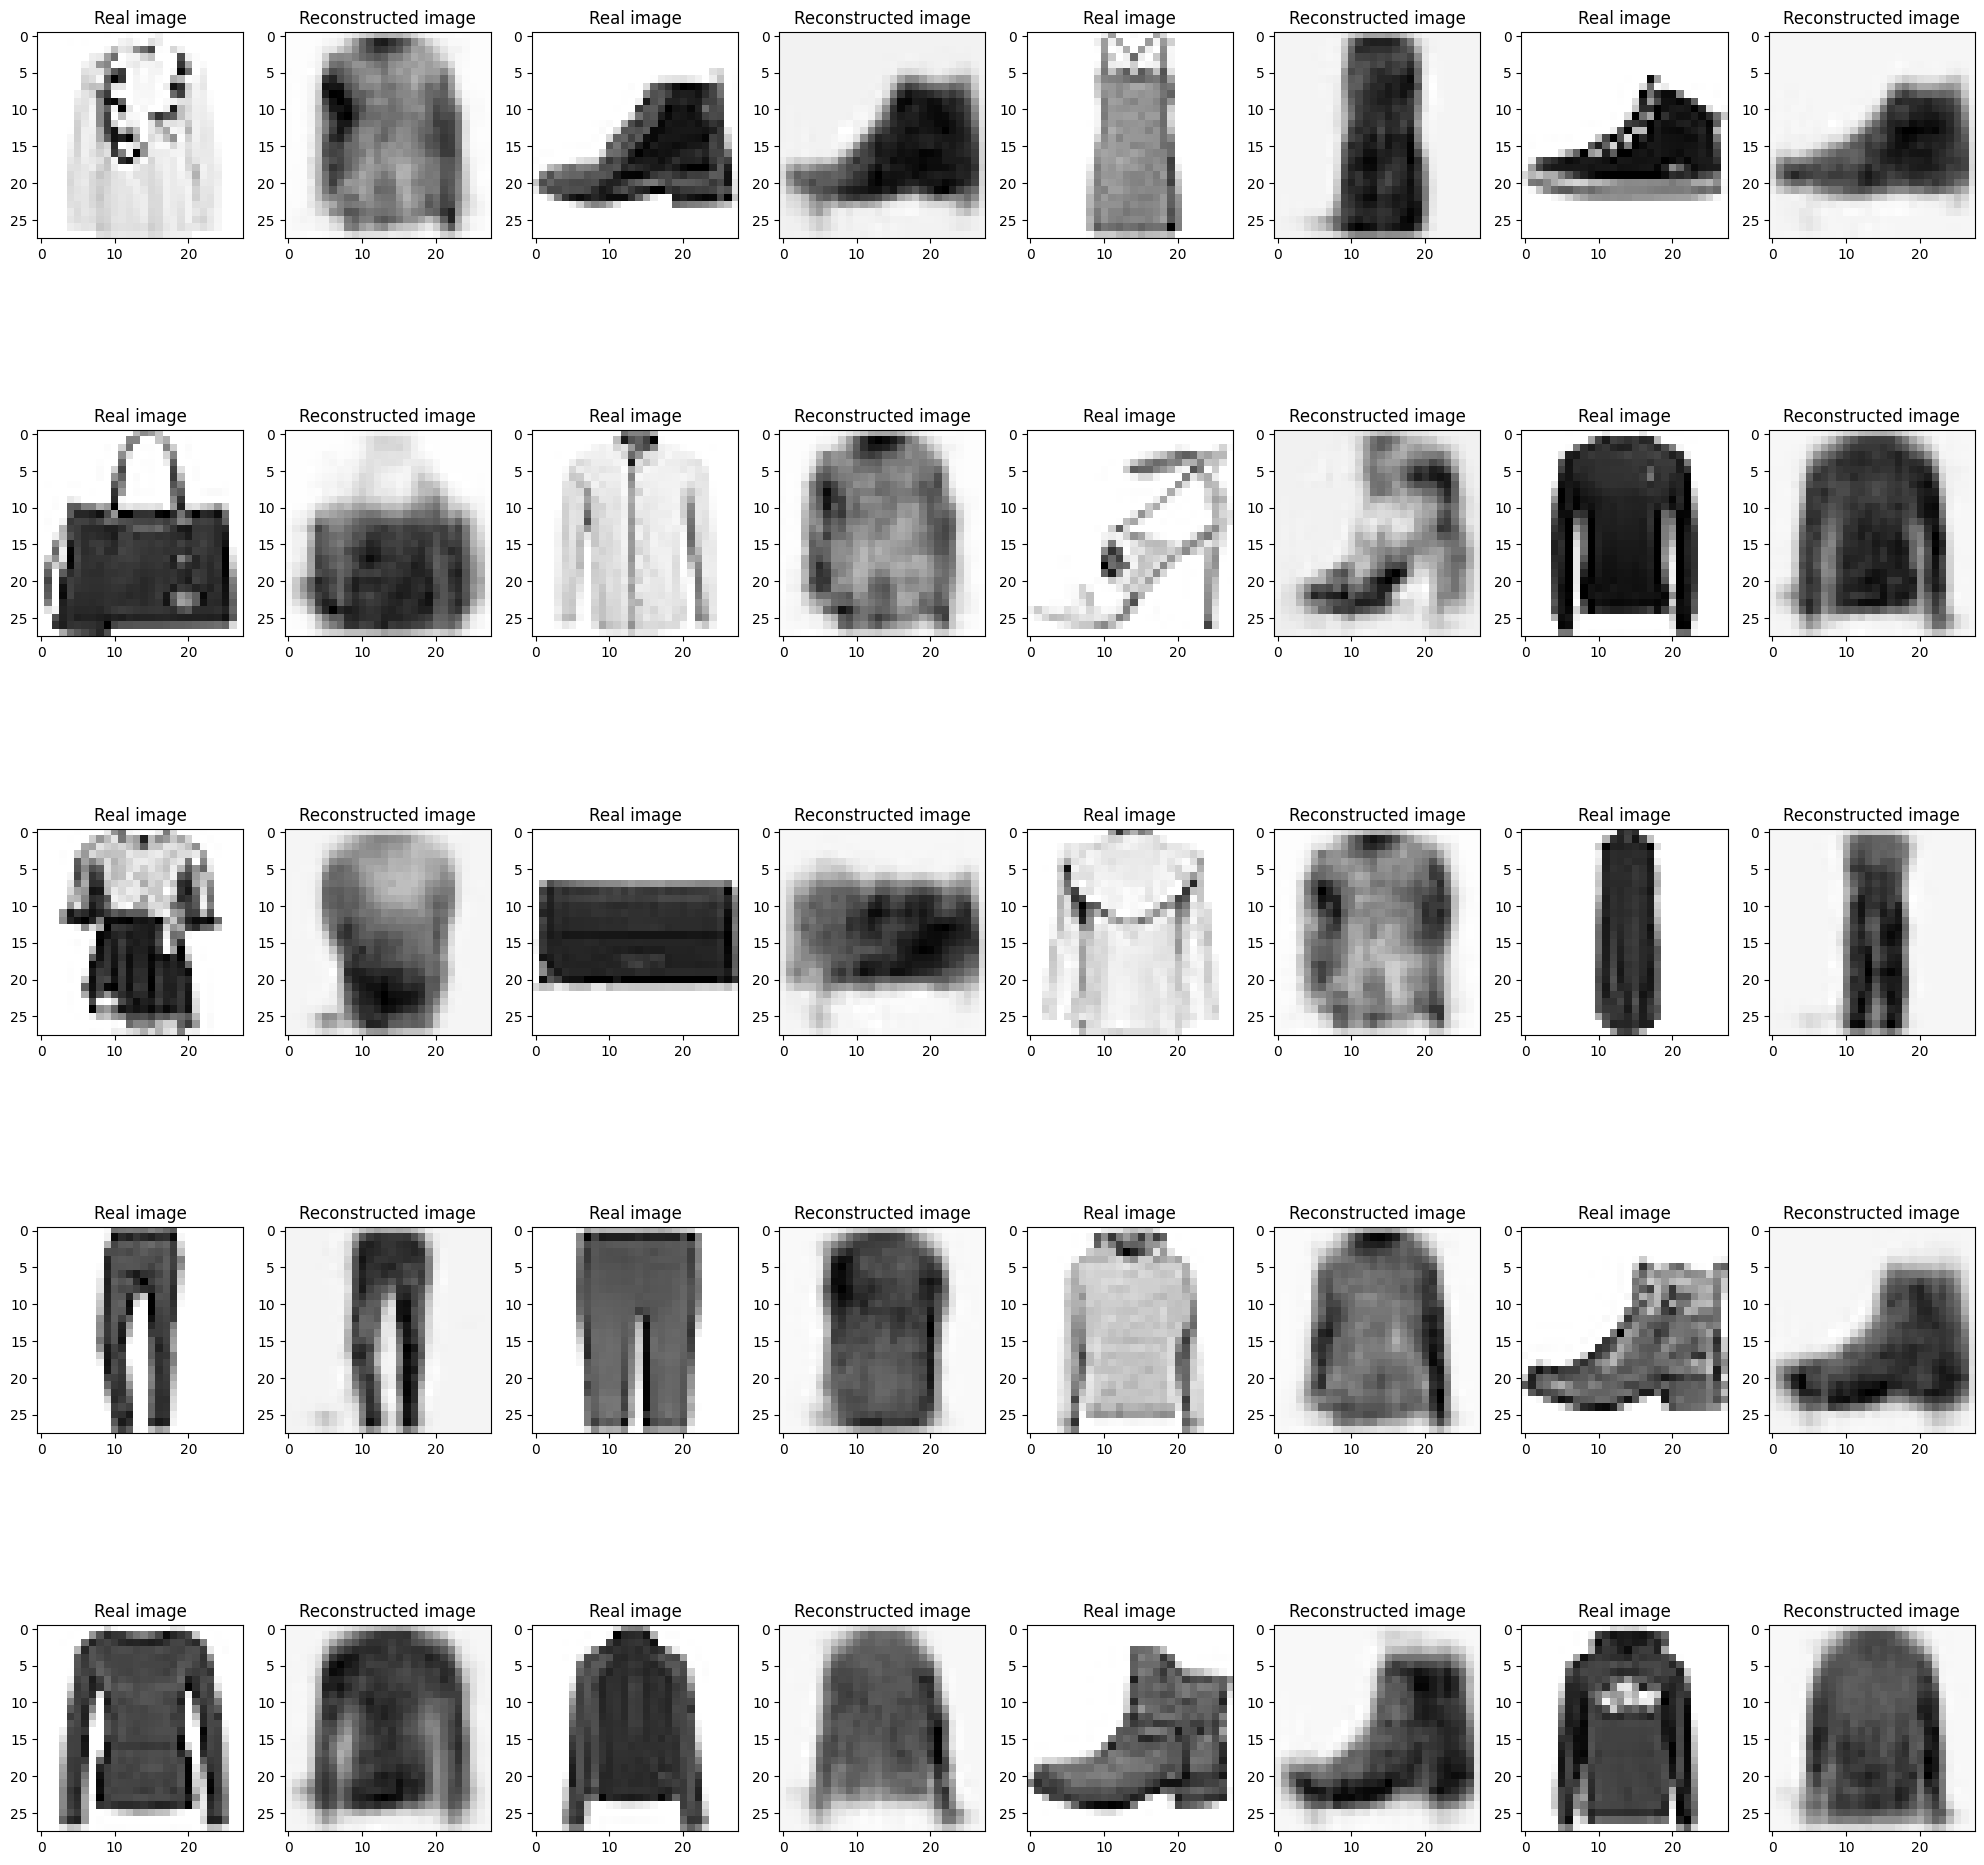

In [28]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(5,8, figsize=(25,25))
for i in range(5):
    for j in range(4):
        idx = random.randint(0, len(test_images))
        img_out = autoencoder.predict(tf.expand_dims(test_images[idx], axis=0), verbose=0)

        axs[i][2*j].imshow(test_images[idx], cmap='Greys')
        axs[i][2*j].title.set_text('Real image')
        axs[i][2*j+1].imshow(tf.squeeze(img_out), cmap='Greys')
        axs[i][2*j+1].title.set_text('Reconstructed image')

plt.show()